In [1]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    #model = "mistral-small:22b-instruct-2409-q6_K",
    model = "qwen2.5:32b-instruct-q6_K",
    temperature = 0.2,
    num_ctx=32768,
    num_predict = 5120,
)

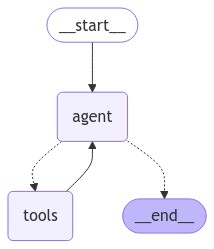

{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b-instruct-q6_K', 'created_at': '2024-09-23T14:53:51.988687Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'collatz', 'arguments': {'n': 9}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 5020754209, 'load_duration': 31684542, 'prompt_eval_count': 299, 'prompt_eval_duration': 3111656000, 'eval_count': 20, 'eval_duration': 1871999000}, id='run-1abb20b6-d7e6-4dde-b72c-ff23ed43a2ff-0', tool_calls=[{'name': 'collatz', 'args': {'n': 9}, 'id': 'f2999643-2d1f-4f5b-a9e7-4327bc0e0876', 'type': 'tool_call'}], usage_metadata={'input_tokens': 299, 'output_tokens': 20, 'total_tokens': 319})]}}
{'tools': {'messages': [ToolMessage(content='28', name='collatz', tool_call_id='f2999643-2d1f-4f5b-a9e7-4327bc0e0876')]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:32b-instruct-q6_K', 'crea

In [3]:
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
#from langchain_core.runnables import RunnableConfig

# Define the Collatz function
def collatz(n: int) -> int:
    """Apply the collatz operation to a number"""
    return 3 * n + 1 if n % 2 else n // 2

# Create the LLM and bind the tool
llm = llm.bind_tools([collatz])

# Define the state
class State(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    collatz_sequence: Sequence[int]

def format_sequence(s: Sequence[int]) -> str:
    return "->".join(str(x) for x in s)

# Create the prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are calculating the Collatz sequence for numbers. Use the collatz tool to generate the next number in the sequence from the last number in the sequence. Collatz sequences end in a loop like \"4->2->1\".\nTips\nThis requires patience and a meticulous approach. Be sure to follow a serial process: wait for each call to the tool to complete before making another call. DO NOT make repeat calls to the tool. You must STOP calling the tool when you reach 4, 2, or 1, and respond with the complete sequence you have generated."),
    ("human", "Generate the collatz sequence. STOP when the last number in the sequence is 4, 2, or 1. The current sequence is: {sequence}. When you are finished, tell me the completed sequence.")
])

# Define the agent function
def agent(state: State) -> State:
    messages = state.get("messages", [])
    values = state.get("collatz_sequence", [])
    if messages and isinstance(messages[-1], ToolMessage):
        values.append(int(state["messages"][-1].content))

    msg = llm.invoke(prompt.format_messages(sequence=format_sequence(values)))

    # Generate the next number in the sequence
    return {"messages": [msg]}

# Create the graph
workflow = StateGraph(State)
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([collatz]))

workflow.add_conditional_edges(
    "agent",
    # If the latest message (result) from agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from agent is a not a tool call -> tools_condition routes to END
    tools_condition
)
workflow.add_edge("tools", "agent")

workflow.set_entry_point("agent")


# Compile the graph
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Run the graph
inputs = {"messages": [], "collatz_sequence": [9]}

config = {"configurable": {"thread_id": "1"}, "recursion_limit": 1024}
#o = app.invoke(inputs)
#print(o["collatz_sequence"])
for upd in app.stream(inputs, config, stream_mode="updates"):
    print(upd)

print(format_sequence(app.get_state(config).values["collatz_sequence"]))
print("Sequence complete. Reached the 4->2->1 loop.")